- SEnet 논문에서 주장한 모델 사진

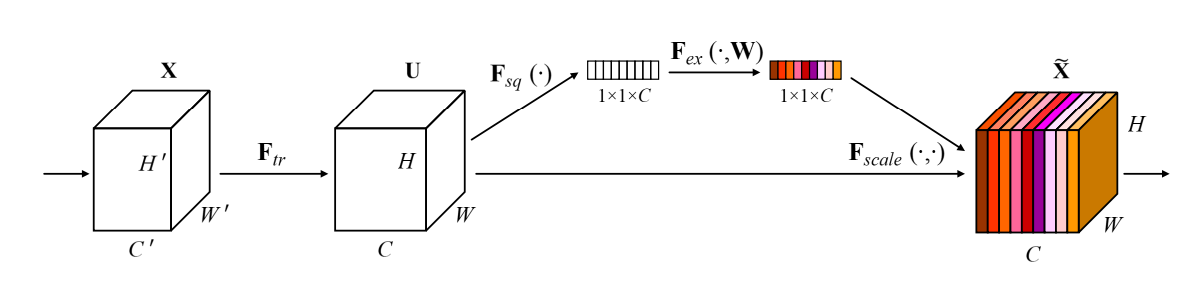

#### Channel_Attention 학습을 위한 코드

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )


        # SE layers
        self.fc1 = nn.Conv2d(planes, planes//16, kernel_size=1)  # Use nn.Conv2d instead of nn.Linear
        self.fc2 = nn.Conv2d(planes//16, planes, kernel_size=1)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        # Squeeze
        w = F.avg_pool2d(out, out.size(2))
        w = F.relu(self.fc1(w))
        w = F.sigmoid(self.fc2(w))

        # Excitation
        out = out * w  # New broadcasting feature from v0.2!

        out += self.shortcut(x)
        out = F.relu(out)
        return out


class PreActBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(PreActBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)

        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False)
            )

        # SE layers
        self.fc1 = nn.Conv2d(planes, planes//16, kernel_size=1) # layer수를 1/16 으로 줄임
        self.fc2 = nn.Conv2d(planes//16, planes, kernel_size=1) # layer수를 원래대로 복원

    def forward(self, x):
        out = F.relu(self.bn1(x))
        # shortcut 사용 시 논문의 SE-ResNet Module이 됌
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))

        # Squeeze
        w = F.avg_pool2d(out, out.size(2)) # 각 채널의 크기를 1로 만듦
        w = F.relu(self.fc1(w))
        w = F.sigmoid(self.fc2(w)) # sigmoid를 통해 각 채널에 가중치 부여 
        # Excitation
        out = out * w

        out += shortcut # shortcut 사용 시 값이 전달 됌
        return out


class SENet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(SENet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block,  64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def SENet18():
    return SENet(PreActBlock, [2,2,2,2])


def train(net, trainloader, criterion, optimizer, device):
    net.train()
    running_loss = 0.0
    for i, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 100 == 99:
            print(f'[{i + 1}, {running_loss / 100:.3f}]')
            running_loss = 0.0

def test(net, testloader, criterion, device):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    print(f'Test Loss: {test_loss / len(testloader):.3f} | Accuracy: {100. * correct / total:.3f}%')

def main():
    # Data preparation
    transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
    
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # SENet18을 이용하여 학습
    net = SENet18().to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    
    for epoch in range(20):
        print(f'Epoch: {epoch + 1}')
        train(net, trainloader, criterion, optimizer, device)
        test(net, testloader, criterion, device)
        scheduler.step()
    
    # Save the trained model
    torch.save(net.state_dict(), 'senet_cifar10.pth')

if __name__ == '__main__':
    main()

c:\Users\islab\.conda\envs\mings\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Files already downloaded and verified
Files already downloaded and verified
Epoch: 1


c:\Users\islab\.conda\envs\mings\lib\site-packages\torch\nn\functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[100, 1.904]
[200, 1.602]
[300, 1.423]
Test Loss: 1.268 | Accuracy: 54.250%
Epoch: 2
[100, 1.132]
[200, 1.041]
[300, 0.980]
Test Loss: 1.365 | Accuracy: 56.970%
Epoch: 3
[100, 0.870]
[200, 0.824]
[300, 0.771]
Test Loss: 0.745 | Accuracy: 74.470%
Epoch: 4
[100, 0.685]
[200, 0.675]
[300, 0.677]
Test Loss: 0.705 | Accuracy: 75.500%
Epoch: 5
[100, 0.613]
[200, 0.596]
[300, 0.587]
Test Loss: 0.917 | Accuracy: 69.010%
Epoch: 6
[100, 0.549]
[200, 0.566]
[300, 0.519]
Test Loss: 0.776 | Accuracy: 74.550%
Epoch: 7
[100, 0.521]
[200, 0.519]
[300, 0.520]
Test Loss: 0.710 | Accuracy: 76.340%
Epoch: 8
[100, 0.502]
[200, 0.506]
[300, 0.479]
Test Loss: 0.694 | Accuracy: 75.880%
Epoch: 9
[100, 0.461]
[200, 0.479]
[300, 0.470]
Test Loss: 0.738 | Accuracy: 73.660%
Epoch: 10
[100, 0.449]
[200, 0.481]
[300, 0.462]
Test Loss: 0.624 | Accuracy: 78.970%
Epoch: 11
[100, 0.436]
[200, 0.442]
[300, 0.450]
Test Loss: 0.660 | Accuracy: 77.760%
Epoch: 12
[100, 0.416]
[200, 0.450]
[300, 0.434]
Test Loss: 0.704 | Accu

#### SENet 시각화를 위한 코드

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import os
import numpy as np

class SENetWithFeatures(SENet):
    def __init__(self, block, num_blocks, num_classes=10):
        super(SENetWithFeatures, self).__init__(block, num_blocks, num_classes)

    # 각 layer의 feature를 저장
    def forward(self, x):
        input_img = x.detach().cpu().numpy()
        out = F.relu(self.bn1(self.conv1(x)))
        features_layer1 = out.detach().cpu().numpy()
        out = self.layer1(out)
        features_layer2 = out.detach().cpu().numpy()
        out = self.layer2(out)
        features_layer3 = out.detach().cpu().numpy()
        out = self.layer3(out)
        features_layer4 = out.detach().cpu().numpy()
        out = self.layer4(out)
        features_layer5 = out.detach().cpu().numpy()
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out, [features_layer1, features_layer2, features_layer3, features_layer4, features_layer5]

def load_model(model_path, device):
    net = SENetWithFeatures(PreActBlock, [2,2,2,2])
    net.load_state_dict(torch.load(model_path, map_location=device))
    net.to(device)
    return net

def save_feature_maps(feature_maps, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    for i, feature_map in enumerate(feature_maps):
        np.save(os.path.join(output_dir, f'feature_map_layer_{i+1}.npy'), feature_map)

def main():
    # Data preparation
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=2)
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Load the trained model
    model_path = 'senet_cifar10.pth'
    net = load_model(model_path, device)
    
    # Extract and save feature maps for a sample input
    net.eval()
    sample_inputs, _ = next(iter(testloader))
    sample_inputs = sample_inputs.to(device)
    _, feature_maps = net(sample_inputs)
    
    # Save feature maps
    output_dir = 'feature_maps'
    save_feature_maps(feature_maps, output_dir)
    print(f'Feature maps saved in {output_dir}')

if __name__ == '__main__':
    main()


Files already downloaded and verified
Feature maps saved in feature_maps


#### 저장한 npy 파일 시각화

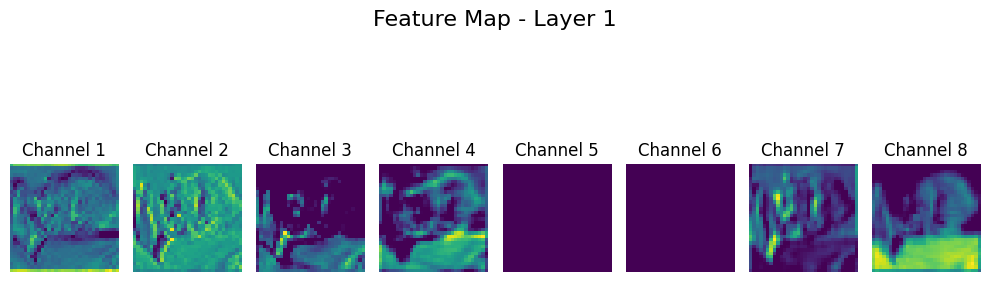

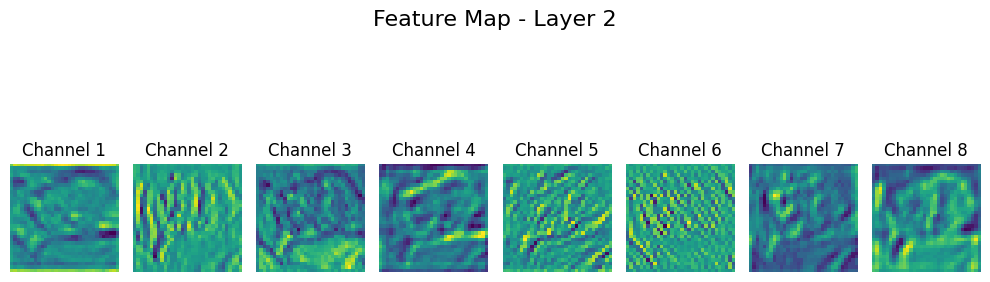

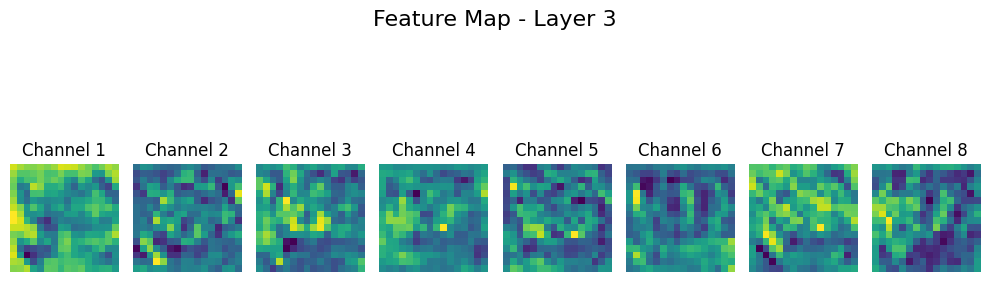

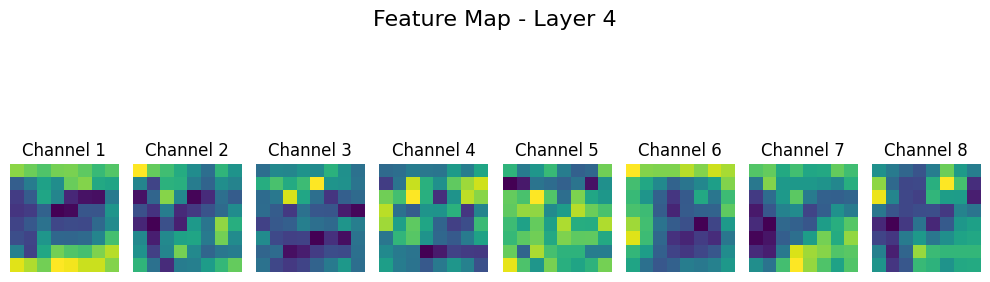

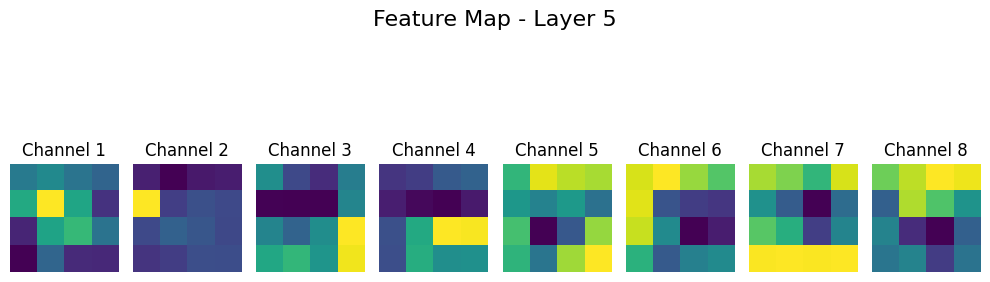

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import os

def visualize_feature_map(feature_map, layer_idx, num_channels=8, save_dir='feature_map_visualizations'):

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # Select the first 'num_channels' channels
    channels = feature_map[0, :num_channels, :, :]
    
    # Create a figure to display the feature maps
    fig, axs = plt.subplots(1, num_channels, figsize=(10, 4))
    
    for i in range(num_channels):
        axs[i].imshow(channels[i], cmap='viridis')
        axs[i].axis('off')
        axs[i].set_title(f'Channel {i+1}')
    
    plt.suptitle(f'Feature Map - Layer {layer_idx + 1}', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)

    # Save the figure
    plt.savefig(os.path.join(save_dir, f'feature_map_layer_{layer_idx + 1}.png'))
    plt.show()

def main():
    output_dir = 'feature_maps'
    save_dir = 'feature_map_visualizations'
    
    # Load and visualize each feature map
    for layer_idx in range(5):  # Assuming there are 5 layers
        feature_map = np.load(os.path.join(output_dir, f'feature_map_layer_{layer_idx + 1}.npy'))
        visualize_feature_map(feature_map, layer_idx, num_channels=8, save_dir=save_dir)

if __name__ == '__main__':
    main()
